<a href="https://colab.research.google.com/github/mlukan/GDA3B2021/blob/main/NN/NN_Hyperparameters_Keras_Quest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Neural Networks using Keras 



### Outline
Our goal is to tune the Apple Store NN for multi-class classification. We need to make several decisions when configuring our NN and focus on finding the optimal parameters for the
 - number of hidden layers
 - number of neurons in hidden layers
 - activation functions
 - type of weight initialization
 - learning rate and momentum
 - optimizer
 - size of batch
 - number of epochs
 - regularization (dropout)



In a first Part of this Notebook we will use Grid Search for Hyperparameter Tuning.

Then in a second Part we will use Keras-Tuner

In [1]:
# Setting up the environment: import standard libraries and load the data. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#This package provides utilities for Keras, such as modified callbacks, data genereators, encoder, etc.
from keras.utils import np_utils






## Use case: app rating analysis
NNs often **solve classification problems with many classes**. To illustrate their functioning in a context that is more related to NLP examples,we introduce the data set concerned with app ratings. The **original data is available on Kaggle**. There, you also find a data dictionary with some information on the variables. However, the variable names are rather self-explanatory. A cleaned version of the data is available in this folder. The easiest way for you is to use the cleaned version but feel very free to play around with the version on Kaggle. You can find a Python script that starts from the original data and goes through a couple of pre-processing operations to produce the version we use below (**app_store_dpp.py**).

In [2]:
# Load dataset and set app name as index

app = pd.read_csv("https://raw.githubusercontent.com/murpi/wilddata/master/quests/AppleStore_prep.csv", 
                  index_col=False, sep='\t', encoding='utf-8')
app = app.set_index('track_name')
#app.info()
app.describe()

,size_bytes,price,rating_count_tot,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,currency_USD,cont_rating_12+,cont_rating_17+,...,prime_genre_Photo & Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather,user_rating
count,7.197000e+03,7.197000e+03,7197.000000,7.197000e+03,7.197000e+03,7.197000e+03,7.197000e+03,7197.0,7197.000000,7197.000000,...,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000,7197.000000
mean,-7.898210e-18,-2.764374e-17,0.000000,-4.985745e-16,-9.181669e-17,-4.738926e-17,5.805185e-16,1.0,0.160484,0.086425,...,0.048492,0.024733,0.008893,0.016952,0.023204,0.015840,0.011255,0.034459,0.010004,3.380992
std,1.000069e+00,1.000069e+00,1.000069,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,0.0,0.367079,0.281010,...,0.214819,0.155320,0.093887,0.129099,0.150562,0.124865,0.105497,0.182417,0.099526,1.434571
min,-5.527689e-01,-2.959602e-01,-0.170239,-7.588536e+00,-1.866742e+00,-6.863082e-01,-1.195575e+01,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.237732e-01,-2.959602e-01,-0.169869,-9.680849e-02,-3.560663e-01,-5.600303e-01,8.364175e-02,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,-2.839269e-01,-2.959602e-01,-0.166278,-9.680849e-02,6.510507e-01,-5.600303e-01,8.364175e-02,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,-4.791329e-02,4.522548e-02,-0.133360,1.707532e-01,6.510507e-01,3.239150e-01,8.364175e-02,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
max,1.065431e+01,5.113736e+01,39.107631,2.578809e+00,6.510507e-01,8.784534e+00,8.364175e-02,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


So **36 columns**, **one of which is the target variable**. We consider the **user rating as our target** and will try to set up a NN that predict the rating from the app characteristics including information on its price, genre, etc.

Let's have a quick look at the target variable. Note that we that we have reduced the number of rating classes compared to the original version of the data on Kaggle (see app_store_dpp.py for details).  


/home/A19893678/local/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


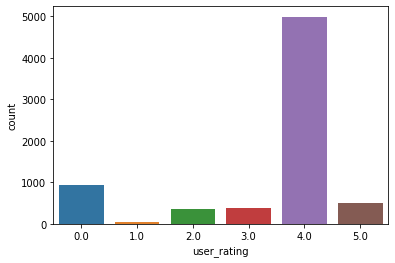

In [3]:
# Inspect the target
import seaborn as sns
sns.countplot(app.user_rating);

In [4]:
app["user_rating"]

track_name
PAC-MAN Premium                                       4.0
Evernote - stay organized                             4.0
WeatherBug - Local Weather, Radar, Maps, Alerts       4.0
eBay: Best App to Buy, Sell, Save! Online Shopping    4.0
Bible                                                 4.0
                                                     ... 
Kubik                                                 4.0
VR Roller-Coaster                                     4.0
Bret Michaels Emojis + Lyric Keyboard                 4.0
VR Roller Coaster World - Virtual Reality             4.0
Escape the Sweet Shop Series                          5.0
Name: user_rating, Length: 7197, dtype: float64

In [5]:
# Prepare the target variable
# LabelEncoder() transforms a string vector to a num vector
encoder = LabelEncoder()
#fit label encoder
encoder.fit(app["user_rating"])
#transform and return encoded labels
encoder.transform(app["user_rating"])
ord_y=encoder.transform(app["user_rating"])



In [6]:
dummy_y = np_utils.to_categorical( encoder.transform(app["user_rating"])).astype(int)
dummy_y.shape[1]

6

In [7]:
import numpy as np

def ord_enc(nparr):
    for x in nparr:
        for i in range(nparr.shape[1]):
            if x[-i]==1:
                x[-i-1]=1
    return(nparr)

ord_y=ord_enc(dummy_y.copy())
#dummy_y
ord_y

array([[1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0],
       ...,
       [1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1]])

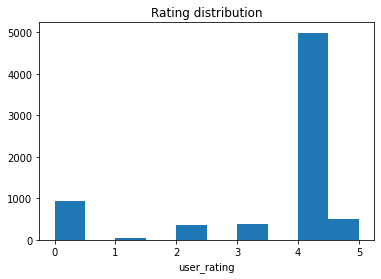

(5037, 35)
(5037, 6)


array([[1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0],
       ...,
       [1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0]])

In [10]:
plt.hist(dummy_y.argmax(axis=1))
plt.xlabel('user_rating')
plt.title('Rating distribution')
plt.show();

# Let's split our data set

#Seed function is used to save the state of a random function, so that it can generate same random numbers on multiple executions of the code on the same machine or on different machines (for a specific seed value)
seed=42

X = app.iloc[:,:-1].values
y = dummy_y.copy()
y1 = ord_enc(dummy_y.copy())
# Keep in mind that this data set is already standardized, which leads to a leakage of information from train set to test set
# When you are working with a dataset, make sure you standardize the variables in test set according to the parameters of the train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)
X1_train, X1_test, y1_train, y1_test = train_test_split(X, ord_y, test_size=0.30, random_state=seed)
    
print (X_train.shape)
print(y_train.shape) 
y1_train


### Preparing the Keras framework ###

Today we will revise the architecture of our basic neural network and look more into the tuning of hyperparameters.



In [11]:
nb_units = 128
# And finally the outout layer
nb_classes = y.shape[1]

In [12]:
# Import Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD


model = Sequential()
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed), input_shape=(X.shape[1],)))
#model.add(Dropout(0.1))
model.add(Dense(nb_units, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
#model.add(Dropout(0.1))
#model.add(Dense(nb_classes, activation='softmax'))
model.add(Dense(nb_classes, activation='softmax'))
model.summary()

batch_size = 56 #1 for online SGD

# example: start tarining the model up until 30 epochs and plot the training loss values and validation loss values against number of epochs.
epochs = 30


model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])
# Fit the model
story = model.fit(X_train, y_train, #name model differently
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                 validation_data=(X_test, y_test))
                    #validation_split=0.33)#validation_data=(X_test, y_test)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 21,894
Trainable params: 21,894
Non-trainable params: 0
_________________________________________________________________


In [13]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story.history['accuracy'])
    ax1.plot(story.history['val_accuracy'])
    ax1.set(xlabel='epoch', ylabel='accuracy')
    ax1.legend(['train_accuracy', 'test_accuracy'], loc='best')
    ax1.set_title('Accuracy evolution during NN training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()


In [12]:
score = model.evaluate(X_test, y_test, verbose=0)

Test loss: 0.9554803967475891
Test accuracy: 0.7037037014961243


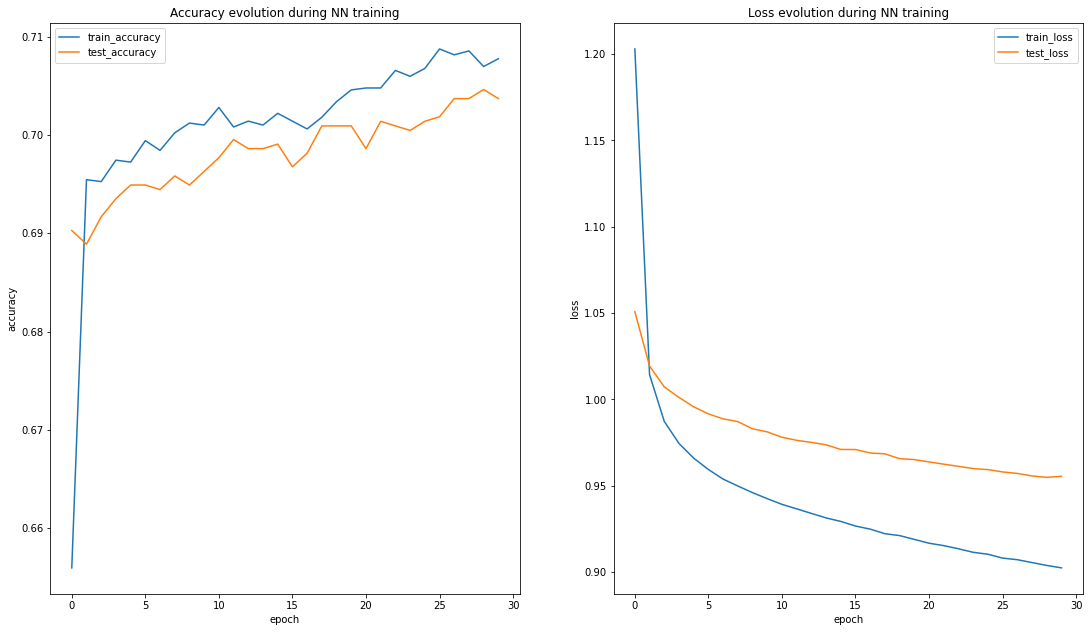

In [13]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])
show_history(story)
del score,story

# Part 1: Hyperparameter optimization with Keras





We will start with the old-fashioned way with Scikit Learn and will first show you an example of how to use GridSearch with two groups of hyperparameters: batches/epochs and optimizer algorithms. 

In [107]:
import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers

In [15]:
#We will use the architecture we had before and wrap it into the function called 'netowork ' (or whatever you want to call it)

def network():
    
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    model.add(Dense(6, activation='softmax',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    
    model.compile(optimizer=optimizers.SGD(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy']) #nothing changes here

    return model

# Now we will plug it into Keras Classifier Wrapper 
model = KerasClassifier(build_fn=network, verbose=0)

In [16]:
# Let's define the grid search parameters
batchsize = [32, 64, 128, 256, 512]
epochs = [10,30,60,70]

In [17]:
#Set the grid
param_grid = dict(batch_size=batchsize, epochs=epochs)# setting a dictionary to store the results
param_grid 

{'batch_size': [32, 64, 128, 256, 512], 'epochs': [10, 30, 60, 70]}

In [18]:
%%time
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1,cv=3) #parallelization, here using all processors
results = grid.fit(X_train, y_train) #remember that we don't want to use the test set in CV
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.710145 using {'batch_size': 32, 'epochs': 70}
CPU times: user 8.58 s, sys: 412 ms, total: 8.99 s
Wall time: 1min 22s


In [19]:
%%time
#Let's now take this knowledge and apply it to our optimizers tuning

def optim (optimizer='SGD'):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
  
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
 
    model.add(Dense(6, activation='softmax',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

model = KerasClassifier(build_fn=optim, epochs=30, batch_size=64, verbose=0)
# define the grid search parameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizers) # setting a dictionary to store the results
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (reember these are the resultson the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.709946 using {'optimizer': 'Adamax'}
CPU times: user 2.62 s, sys: 122 ms, total: 2.75 s
Wall time: 25.6 s


In [20]:
%%time
#Let's now take this knowledge and apply it to our optimizers tuning

def optim (optimizer='SGD'):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
  
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
 
    model.add(Dense(6, activation='sigmoid',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model

model = KerasClassifier(build_fn=optim, epochs=30, batch_size=64, verbose=0)
# define the grid search parameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizers) # setting a dictionary to store the results
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
results = grid.fit(X_train, y_train)

# Our results (reember these are the resultson the hold-out data)
print("Best: %f using %s" % (results.best_score_, results.best_params_))

Best: 0.708755 using {'optimizer': 'Nadam'}
CPU times: user 3.41 s, sys: 85.6 ms, total: 3.5 s
Wall time: 27.2 s


Now continue using Grid Search to tune the Learning Rate and Momentum:

In [21]:
%%time
from keras.optimizers import Adamax
lrates=[0.0001,0.001,0.01,0.1]
moms=[0.0001,0.001,0.01,0.1]
def optimize_lr_mom(lr=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed),  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    model.add(Dense(6, activation='softmax',kernel_initializer=keras.initializers.he_normal(seed=seed)))
    optimizer=SGD(lr=lr,momentum=momentum)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
param_grid1 = dict(lr=lrates, momentum=moms)
model1 = KerasClassifier(build_fn=optimize_lr_mom, epochs=30, batch_size=64, verbose=0)
grid1 = GridSearchCV(estimator=model1, param_grid=param_grid1, n_jobs=-1, cv=3)
results1 = grid1.fit(X_train, y_train)
print("Best: %f using %s" % (results1.best_score_, results1.best_params_))


Best: 0.709152 using {'lr': 0.1, 'momentum': 0.01}
CPU times: user 2.38 s, sys: 95 ms, total: 2.48 s
Wall time: 51.4 s


Use Grid Search to tune the Network Weight Initialization:

In [39]:
%%time
from keras import initializers
from keras.optimizers import Adamax,Adam
inits = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
def optimize_inits(inits='he_normal'):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=inits,  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer=inits))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
param_grid2 = dict(inits=inits)
model2 = KerasClassifier(build_fn=optimize_inits, epochs=30, batch_size=64, verbose=0)
grid2 = GridSearchCV(estimator=model2, param_grid=param_grid2, n_jobs=-1, cv=3)
results2 = grid2.fit(X_train, y_train)
print("Best: %f using %s" % (results2.best_score_, results2.best_params_))


Best: 0.714116 using {'inits': 'glorot_uniform'}
CPU times: user 2.46 s, sys: 110 ms, total: 2.57 s
Wall time: 27.4 s


Use Grid Search to tune the Neuron Activation Function


In [38]:
%%time
from keras import initializers
acts=['tanh','relu','sigmoid']
def optimize_acts(acts='relu'):
    model = Sequential()
    model.add(Dense(128, activation=acts,bias_initializer='zeros',kernel_initializer='uniform',  input_shape=(X.shape[1],)))
    model.add(Dense(128, activation=acts,bias_initializer='zeros',kernel_initializer='uniform'))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
param_grid3 = dict(acts=acts)
model3 = KerasClassifier(build_fn=optimize_acts, epochs=30, batch_size=64, verbose=0)
grid3 = GridSearchCV(estimator=model3, param_grid=param_grid3, n_jobs=-1, cv=3)
results3 = grid3.fit(X_train, y_train)
print("Best: %f using %s" % (results3.best_score_, results3.best_params_))

Best: 0.712130 using {'acts': 'relu'}
CPU times: user 2.62 s, sys: 122 ms, total: 2.75 s
Wall time: 12.2 s


Use Grid Search to tune Dropout Regularization

In [48]:
%%time
from keras import initializers
drops=[0,.1,.5]
def optimize_dropo(drops=0):
    model = Sequential()
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer='uniform',  input_shape=(X.shape[1],)))
    model.add(Dropout(drops))
    model.add(Dense(128, activation='relu',bias_initializer='zeros',kernel_initializer='uniform'))
    model.add(Dropout(drops))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
param_grid4 = dict(drops=drops)
model4 = KerasClassifier(build_fn=optimize_dropo, epochs=30, batch_size=64, verbose=0)
grid4 = GridSearchCV(estimator=model4, param_grid=param_grid4, n_jobs=-1, cv=3)
results4 = grid4.fit(X_train, y_train)
print("Best: %f using %s" % (results4.best_score_, results4.best_params_))

Best: 0.711932 using {'drops': 0.1}
CPU times: user 3.04 s, sys: 104 ms, total: 3.14 s
Wall time: 15.8 s


Use Grid Search to tune the Number of Neurons in the Hidden Layer

In [108]:
%%time
neurons=list(range(32,257,32))
def optimize_neurons(neurons=32):
    model = Sequential()
    model.add(Dense(neurons, activation='relu',bias_initializer='zeros',kernel_initializer='uniform',  input_shape=(X.shape[1],)))
    model.add(Dropout(.5))
    model.add(Dense(neurons, activation='relu',bias_initializer='zeros',kernel_initializer='uniform'))
    model.add(Dropout(.5))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
param_grid5 = dict(neurons=neurons)
model5 = KerasClassifier(build_fn=optimize_neurons, epochs=100, batch_size=64, verbose=0)
grid5 = GridSearchCV(estimator=model5, param_grid=param_grid5, n_jobs=-1, cv=3)
results5 = grid5.fit(X_train, y_train)
print("Best: %f using %s" % (results5.best_score_, results5.best_params_))

Best: 0.717093 using {'neurons': 96}
CPU times: user 7.92 s, sys: 436 ms, total: 8.36 s
Wall time: 1min 52s


In [131]:
preds5=results5.predict(X_test)

len(preds5)

2160

In [ ]:
print(y_test.shape,preds5.shape)

obs=[]
for r in y_test:
    for i,x in enumerate(r):
        if x==1:
            obs.append(i)
obs

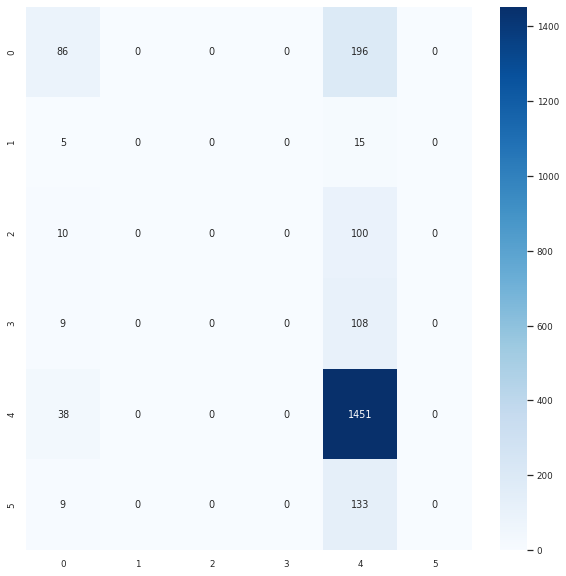

In [142]:
#preds5=results5.best_estimator_.predict(X_test)

from sklearn.metrics import confusion_matrix
#yhat=net.predict_classes(X_test)
cm=confusion_matrix(obs,preds5)
class_names=list(range(6))
import seaborn as sn
import pandas as pd


df_cm = pd.DataFrame(cm, class_names, class_names)
plt.figure(figsize=(10,10))
sn.set(font_scale=.8) # for label size
sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g') # font size

plt.show()

# Part 2:  Keras Tuner

In [23]:
from kerastuner import HyperModel


In [22]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

Read through the Keras Tuner Documentation and build a RandomSearch. This hyperparameter tuning method randomly tries a combination of hyperparameters from a given search space. To use this method in keras tuner, first define a tuner using one of the available [Tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/).


In [29]:
from kerastuner import HyperModel
from keras.optimizers import Adamax,SGD,Adam
class ClassificationHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = Sequential()
        model.add(
            layers.Dense(
                units=hp.Int('units', 64, 257, 32, default=128),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=input_shape
            )
        )
        
        model.add(
            layers.Dense(
                units=hp.Int('units', 64, 257, 32, default=128),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )
        
        model.add(
            layers.Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.1,
                    max_value=0.5,
                    default=0.005,
                    step=0.05)
            )
        )
        
        model.add(layers.Dense(6, activation='softmax'))
        
        model.compile(
            optimizer=Adamax(),loss='categorical_crossentropy',metrics=['accuracy']
        )
        
        return model

In [30]:
input_shape = (X_train.shape[1],)
hypermodel = ClassificationHyperModel(input_shape)

In [31]:
'''
y1_train=y1_train.reshape(5037,1)
y1_test=y1_test.reshape(y1_test.shape[0],1)
y1_train.shape
'''

'\ny1_train=y1_train.reshape(5037,1)\ny1_test=y1_test.reshape(y1_test.shape[0],1)\ny1_train.shape\n'

In [32]:
%%time
try:
    del tuner_rs
except:
    pass
tuner_rs = RandomSearch(
            hypermodel,
            objective='val_accuracy',
            seed=42,
            max_trials=10,
            executions_per_trial=2)
#tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
tuner_rs.search(X_train,y_train,epochs=5,validation_data=(X_test,y_test))
best_model = tuner_rs.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)
best_model.summary()
#best_model.best_params()

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit
68/68 [==============================] - 0s 542us/step - loss: 0.9882 - accuracy: 0.6968
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                2880      
_________________________________________________________________
dense_1 (Dense)              (None, 80)                6480      
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 486       
Total params: 9,846
Trainable params: 9,846
Non-trainable params: 0
_____________________________________

In [33]:
best_model.evaluate(X_test,y_test)

68/68 [==============================] - 0s 556us/step - loss: 0.9882 - accuracy: 0.6968


[0.9881830215454102, 0.6967592835426331]

In [67]:
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = Sequential()
        model.add(
            layers.Dense(
                units=hp.Int('units', 16, 156, 32, default=16),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=self.input_shape
            )
        )
        
        model.add(
            layers.Dense(
                units=hp.Int('units',16, 156, 32, default=16),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
            )
        )
        
        model.add(
            layers.Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.1,
                    max_value=0.5,
                    default=0.005,
                    step=0.05)
            )
        )
        
        model.add(layers.Dense(1,activation='sigmoid'))
        
        model.compile(
            optimizer='rmsprop',loss='mse',metrics=['mse']
        )
        
        return model

In [68]:
try: 
    del hypermodel1
    del tuner_rs2
except:pass
input_shape = (X1_train.shape[1],)

hypermodel1 = RegressionHyperModel(input_shape)

In [69]:
y1_train.shape

#y1_test.shape

(5037, 1)

In [70]:
%%time
tuner_rs2 = RandomSearch(
            hypermodel1,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2)
#tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)
tuner_rs2.search(X1_train,y1_train,epochs=5,validation_data=(X1_test,y1_test))

#best_model = tuner_rs2.get_best_models(num_models=1)[0]
tuner_rs2.get_best_models()
'''best_model.evaluate(X1_test, y1_test)
best_model.summary()'''
#best_model.best_params()

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


ValueError: Shapes (1,) and (6,) are incompatible